<center><h1>Barcelona's Transit Accidents 2017-2018 <b>Part 3</b>: Modeling.</h1></center>

<p style = "font-family:arial;font-size:19px;">This is a dataset of car accidents that occurred during the years of 2017-2018 in the City of Barcelona, Spain. The raw datasets were obtained from <a href="https://opendata-ajuntament.barcelona.cat/es/">Open Barcelona</a>, preprocessed and analyzed in the first part and second part of this work respectively.</p>

<p style = "font-family:arial;font-size:19px;">For this part of the project we will make a model that predicts the number of vehicles involved in an accident based on geographical and preliminary information.  We also expect to gain some more insights on the data.<br>
There are intrinsic difficulties related to the stochastically and randomness of the studied phenomenon.
A car accident can occur at any moment, any place and with a lot of possible causes. This makes the making of the classification model rather difficult and the expected results limited.<br>
Another factor that will affect our model performance is the natural occurring imbalance of the data. The majority of accidents involved <b><i>2</i></b> cars, followed by <b><i>1</i></b> car accidents, as it was observed before in the second part of this job.</p>

<p style = "font-family:arial;font-size:19px;">First, we will set our environment with all the required modules that we are going to use for this part of the work:</p>

In [1]:
#Setting Ipython display complements:
from IPython.display import HTML

#Setting Numpy for arrays and calculations:
import numpy as np

#Setting Pandas for Dataframes managing:
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Not bother with warning messages
import warnings
warnings.filterwarnings('ignore')

#Setting Matplotlib and Seaborn for graphics:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

#Setting the packages for modeling and ploting:
#import pydotplus 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error

#Making the Notebook use .svg instead of .png. It is slower but improves the quality of the figures.
%config InlineBackend.figure_format = 'svg'


<p style = "font-family:arial;font-size:19px;">The post-processed data frame is in csv format and it is loaded into a variable called df.</p>

In [2]:
#Importing de data frame to the variable df:
df = pd.read_csv('2017_2018_Barcelonas_Accidents.csv', ',')

<p style = "font-family:arial;font-size:19px;">We load our features and target columns to X and y respectively.</p>

In [3]:
#loading the features and the target variable.
X = df[['District Name', 'Neighborhood Name', 'Weekday Number', 'Month Number', 'Day', 'Hour', 'Part of the Day', 'Cause', 'Latitude', 'Longitude', 'Corner']]
yc = np.array(df['Vehicles Involved'])

<p style = "font-family:arial;font-size:19px;">Sklearn implementation of common algorithms uses only numerical features and gives them order. Because of this we need to encode them.</p>

In [4]:
#We need to encode our categorical features:
X = pd.get_dummies(X)

<p style = "font-family:arial;font-size:19px;">The most basic model we can use predicts the number of cars involved in the accident to be <b><i>2</i></b>, as it is the most frequent case. A model like this will have an accuracy of around <b><i>68,02%</i></b>. Any model that has an accuracy lower than this will be worthless.</p>

In [5]:
df['Vehicles Involved'].value_counts(True)*100

2     68.0176
1     21.8356
3      7.7201
4      1.5865
5      0.4498
6      0.1334
7      0.0741
9      0.0544
0      0.0494
8      0.0346
10     0.0198
11     0.0099
14     0.0049
13     0.0049
12     0.0049
Name: Vehicles Involved, dtype: float64

<p style = "font-family:arial;font-size:19px;">Based on the type of problem we want to address and the data available we choose to use a preliminary model based in Decision Tree Classifiers.</p>

<p style = "font-family:arial;font-size:19px;">In Our first attempt a Decision Tree with default parameters is used. We need to split the data into training and test set and see how it performs.</p>

In [6]:
#Splitting the data into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2,random_state=17)

<p style = "font-family:arial;font-size:19px;">As we can see the accuracy obtained is very low, even compared to our basic model. This result can be somehow reasonable as we haven't done any tuning on the parameters.</p>

In [7]:
#Building and fitting the model:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

#Calculating and printing the accuracy:
y_p = tree.predict(X_test)
basic_score = np.round(accuracy_score(y_test, y_p)*100, decimals=2)
print("The model attained an accuracy of {} %".format(basic_score))

The model attained an accuracy of 58.49 %


<p style = "font-family:arial;font-size:19px;">To asses a set of better parameters for this model we perform a grid search and check the accuracy obtained with them.</p>

In [8]:
# Initialize the set of parameters for exhaustive search and fit.
parameters = {'max_features': [5, 10, 15], 
              'min_samples_leaf': [1, 5, 9], 
              'max_depth': [None , 5, 9, 17, 19]}

# Initialize a stratified split for the validation process.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Building the model:
dt = DecisionTreeClassifier(random_state=22)

#Making and fitting the Gridsearch model.
gscv = GridSearchCV(dt, parameters, n_jobs=-1, cv=skf, verbose=1)
gscv.fit(X, yc);

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 218 out of 225 | elapsed:    9.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    9.6s finished


<p style = "font-family:arial;font-size:19px;">We can observe a dramatic improvement compared to the not tuned tree model. <br> Compared with the basic model we can see a considerable improvement of <b><i>4,67%</i></b>. </p>

In [9]:
#Priting the parameters and the score obtained.
tuned_score = np.round(gscv.best_score_*100, decimals=2)
print("The best accuracy obtained was {}% with this parameters: {}".format(tuned_score ,gscv.best_params_))
diff = np.round(tuned_score - basic_score, decimals=2)
print("The improvement achieved over the default tree is {}%".format(diff))
print("The improvement achieved  over the basic model is {}%".format(np.round(tuned_score -68.02 , decimals=2)))

The best accuracy obtained was 72.69% with this parameters: {'max_depth': 9, 'max_features': 10, 'min_samples_leaf': 5}
The improvement achieved over the default tree is 14.2%
The improvement achieved  over the basic model is 4.67%


<p style = "font-family:arial;font-size:19px;">In the next step we are going to make our effective model using Random Forest algorithm. It uses ensembles of trees instead of just one. Compared to the Decision Tree model in general it attain higher accuracy at the trade off of using a lot more resources. </p>

<p style = "font-family:arial;font-size:19px;">As we did before, our first basic attempt is without tuning any of the parameters. This time a stratified <b><i>5</i></b> fold validation is used for evaluation.</p>

<p style = "font-family:arial;font-size:19px;">The accuracy obtained is lower than the one we have got with the tuned Decision Tree but far superior that the one of the default parameters Decision Tree.</p>

In [10]:
# Initialize a stratified split for the validation process.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier with the default parameters.
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

# Training it on the training set.
results = cross_val_score(rfc, X, yc, cv=skf)

# Evaluate the accuracy on the test set.
rf_basic_score = results.mean() * 100
print("Cross Validation accuracy score: {:.2f}%".format(results.mean() * 100))

Cross Validation accuracy score: 70.05%


<p style = "font-family:arial;font-size:19px;">Before we perform a grid search, to get a better understanding on how the model react to changes in the parameters we need to study his learning curves over the <b><i>4</i></b> most important parameters. <br>
It is important no notice that we only change one parameter at a time and the rest are held at their default value: There is no max depth, the minimum sample leaf is <b><i>1</i></b>, the maximum features are set around <b><i>10</i></b> and the number of trees used is <b><i>100</i></b>. </p>

<p style = "font-family:arial;font-size:19px;">Studying the learning curves for each parameter, we see that as the number of trees grown, we gain slightly more accuracy but the model overfits the training data.<br> 
The maximum number of features parameter presents a similar behavior: It adds complexity to the model making it a little more accurate until it reaches a peak. Doing this, it also tends to make the model overfit.<br>
This behavior is expected for both parameters. To solve the overfitting problem, we need to tune the other two parameters as they act as regularization parameters.<br>
As we increase the max depth, we can see how the model have a pronounce increase in the fitting over the training data and small increase in the accuracy over the test data. This parameter plays a crucial role in the regularization of our model. 
We need to find a good balance between both sets to maximize the accuracy and assure the model is not overfitting the training data.<br>
The opposite occurs with the minimum number of samples per leaf. As we increase it, we see an increase in accuracy and a decrease in the overfitting.</p>

In [11]:
#Making the grid of parameters to explore:
number_of_trees_g = [10, 25, 50, 100]
max_features_g = [ 9, 13, 17, 21, 24, 27]
max_depth_g = [7, 9, 13, 15, 17, 19, 21]
min_samples_leaf_g = [3, 5, 7, 9, 13, 15, 17, 19]
parameters_grid = [number_of_trees_g, max_features_g, max_depth_g, min_samples_leaf_g]
parameters_names = ["n_estimators", "max_features", "max_depth", "min_samples_leaf"]


Best CV accuracy is 72.61% with n_estimators = 100
Best CV accuracy is 72.75% with max_features = 24
Best CV accuracy is 73.45% with max_depth = 19
Best CV accuracy is 73.42% with min_samples_leaf = 15


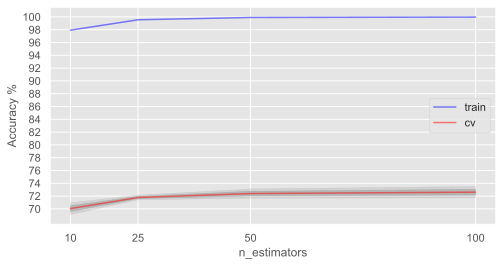

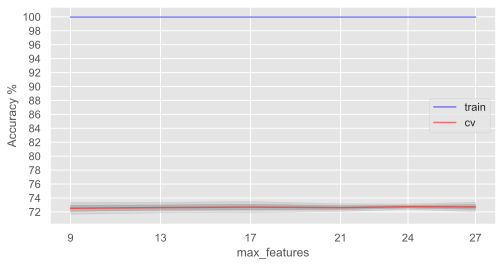

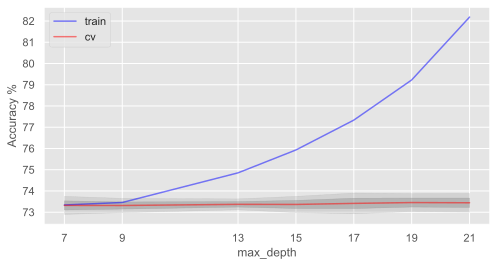

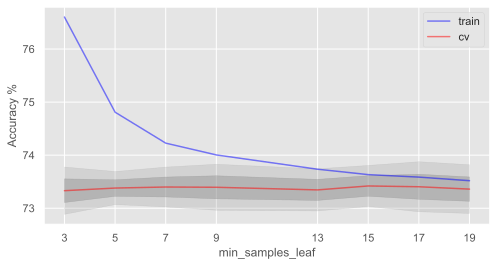

In [12]:
#This will study the curves, print the best scores obtained and plot the learning curves.

for n_grid in range(len(parameters_grid)):
# Create a lists to save the values of accuracy on training and test sets:
    train_scores = []
    test_scores = []
    temporal_train_scores = []
    temporal_test_scores = []

    for parameter in parameters_grid[n_grid]:
        value = {parameters_names[n_grid] : parameter}
        rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rfc.set_params(**value)
        temporal_train_scores = []
        temporal_test_scores = []
        for train_index, test_index in skf.split(X, yc):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = yc[train_index], yc[test_index]
            rfc.fit(X_train, y_train)
            temporal_train_scores.append(rfc.score(X_train, y_train))
            temporal_test_scores.append(rfc.score(X_test, y_test))
        train_scores.append(temporal_train_scores)
        test_scores.append(temporal_test_scores)

#Printing the best scores achieves for each parameter. 
    train_scores, test_scores = np.asarray(train_scores)*100, np.asarray(test_scores)*100
    print("Best CV accuracy is {:.2f}% with {} = {}".format(max(test_scores.mean(axis=1)), parameters_names[n_grid], parameters_grid[n_grid][np.argmax(test_scores.mean(axis=1),)]))

#Plotting the learning curvess.    
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(parameters_grid[n_grid], train_scores.mean(axis=1), alpha=0.5, color='blue', label='train')
    ax.plot(parameters_grid[n_grid], test_scores.mean(axis=1), alpha=0.5, color='red', label='cv')
    ax.fill_between(parameters_grid[n_grid], test_scores.mean(axis=1) - test_scores.std(axis=1), 
                test_scores.mean(axis=1) + test_scores.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(parameters_grid[n_grid], test_scores.mean(axis=1) - 2*test_scores.std(axis=1), 
                test_scores.mean(axis=1) + 2*test_scores.std(axis=1), color='#888888', alpha=0.2)
    ax.legend(loc='best')
    ax.xaxis.set_major_locator(ticker.FixedLocator(parameters_grid[n_grid]))
    ax.set_ylabel("Accuracy %")
    ax.set_xlabel(parameters_names[n_grid]);
#Adjusting the scale for each case.    
    if n_grid > 1 :
        ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(70,102,1))))
    else:
        ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(70,102,2))))

<p style = "font-family:arial;font-size:19px;">The parameters obtained are used as reference to perform a full grid search and find the combination of them that attain the highest accuracy.<br> As we can see below, choosing the right parameters improved our model accuracy by a reasonable amount.</p>

<p style = "font-family:arial;font-size:19px;">Comparing with the other models, we observe that the Random Forest performs better.<br>
Against the tuned Decision Tree, we obtained a <b><i>0.84%</i></b> difference in the accuracy. </p>

In [13]:
# Initialize the set of parameters for exhaustive search and fit 
parameters = {'n_estimators': [25, 50, 100],'max_features': [10, 15, 20, 24], 'min_samples_leaf': [1, 5, 9, 15], 'max_depth': [None , 9, 17, 19]}

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
gscv2 = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gscv2.fit(X, yc);
#gscv.best_params_, gscv.best_score_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 11.3min finished


In [14]:
#Making calculations for the score obtained.
rf_tuned_score = np.round(gscv2.best_score_*100, decimals=2)
diff1 = np.round(rf_tuned_score - rf_basic_score, decimals=2)
diff2 = np.round(rf_tuned_score - tuned_score, decimals=2)

#Printing the scores and the parameters.
print("The best accuracy obtained was {}% with this parameters: {}".format(rf_tuned_score ,gscv2.best_params_))
print("The improvement achieved over the default Random Forest is {}%".format(diff1))
print("The improvement achieved over the tuned Decision Tree is {}%".format(diff2))
print("The improvement achieved  over the basic model is {}%".format(np.round(rf_tuned_score -68.02 , decimals=2)))

The best accuracy obtained was 73.53% with this parameters: {'max_depth': 17, 'max_features': 15, 'min_samples_leaf': 1, 'n_estimators': 25}
The improvement achieved over the default Random Forest is 3.48%
The improvement achieved over the tuned Decision Tree is 0.84%
The improvement achieved  over the basic model is 5.51%


<p style = "font-family:arial;font-size:19px;">As a last step with this model, we check which features are the most important for the prediction.<br>
We can observe above that the most important features are the Cause: "Not Pedestrian at Fault", the LAT, LONG, Day and time of the accident in that order.</p>


Feature ranking:
1. Cause_Not pedestrian at fault--> 14.3%
2. Latitude--> 12.14%
3. Longitude--> 11.36%
4. Day--> 8.85%
5. Hour--> 7.75%
6. Month Number--> 7.0%
7. Cause_Not crossing in the zebra lines--> 6.09%
8. Weekday Number--> 6.04%
9. Cause_Disobeying the stop light--> 5.23%
10. Cause_Other--> 2.67%


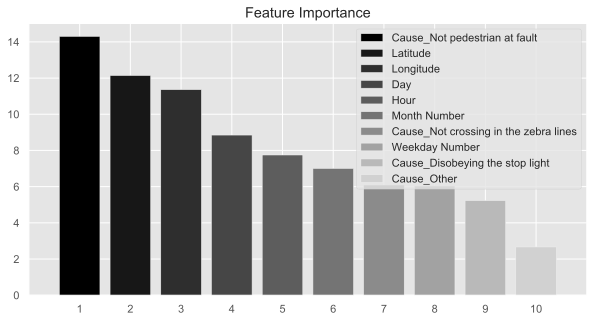

In [24]:
features = {}
for n in range(1,len(X.columns)+1):
    features[str("f" + str(n))] = X.columns[n-1]


rfc = RandomForestClassifier(random_state=42).set_params(**{'max_depth': 17, 'max_features': 15, 'min_samples_leaf': 1, 'n_estimators': 25})

rfc.fit(X, yc)
importances = np.round(np.array(rfc.feature_importances_)*100, decimals=2)
indices = np.argsort(importances)[::-1]
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("{}. {}--> {}%".format(str(f + 1), features["f"+str(feature_indices[f])], str(importances[indices[f]])))
    
    
#Make a plot of the features importance   
plt.figure(figsize=(10,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), importances[indices[:num_to_plot]], color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]), align="center")
#ticks = plt.xticks(range(num_to_plot), feature_indices)
ticks = plt.xticks(range(num_to_plot), range(1,num_to_plot + 1) )
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

<p style = "font-family:arial;font-size:19px;">As an extra step, for comparison, below we try another model called XGboost.<br> 
It has recently got mainstream for winning a lot of data science online competitions. It is also based in Trees but uses a technique named gradient boosting. The main difficulty with this algorithm is the number of parameters to optimize and the amount of resources used for this.<br> Here we use a grid search to tune some of them and check the results. We can not all of them because of the lack of informatic resources.</p>

In [16]:
import os

os.environ["OMP_NUM_THREADS"] = "4"

# Initialize the set of parameters for exhaustive search and fit 
parameters = {'n_estimators': [25, 50, 100],
    'learning_rate' : [0.1, 0.3, 0.5],
              'alpha': [3, 5, 7], 
              'max_depth': [0 , 3, 9]}

xgb_reg = xgb.XGBClassifier(nthread=4, objective='reg:linear', learning_rate=0.1, colsample_bytree=0.5, n_estimators=100)
gscv4 = GridSearchCV(xgb_reg, parameters, n_jobs=-1, cv=skf, verbose=1)
gscv4.fit(X, yc)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 43.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='reg:linear',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [3, 5, 7], 'learning_rate': [0.1, 0.3, 0.5],
                         '

<p style = "font-family:arial;font-size:19px;">We see that the accuracy obtained is similar to the Random Forest model but the resources used are considerable bigger.</p>

In [19]:
print("The best accuracy obtained was {}% with this parameters: {}".format(np.round(gscv4.best_score_*100, decimals=2) ,gscv4.best_params_))

The best accuracy obtained was 73.56% with this parameters: {'alpha': 3, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


<p style = "font-family:arial;font-size:19px;">Studying the features importance of this model we can see that all the "Cause" features got the first <b><i>5</i></b> positions in the list of importance. The Cause: "Not pedestrian at fault" got the <b><i>35%</i></b> only by itself.<br>
We noticed that compared to our Random Forest model the <b><i>10</i></b> most important features are all categorical ones. 
This is related to the way the two Algorithm work: They are both based on Decision Trees but at the same time they are really different.</p>


Feature ranking:
1. Cause_Not pedestrian at fault--> 34.21%
2. Cause_Not crossing in the zebra lines--> 11.25%
3. Cause_Disobeying the stop light--> 7.98%
4. Cause_Other--> 4.86%
5. Cause_Walking by foot on the road--> 4.6%
6. Corner_Yes--> 3.17%
7. District Name_Eixample--> 1.85%
8. Corner_No--> 1.49%
9. Neighborhood Name_el Carmel--> 1.09%
10. District Name_Ciutat Vella--> 0.94%


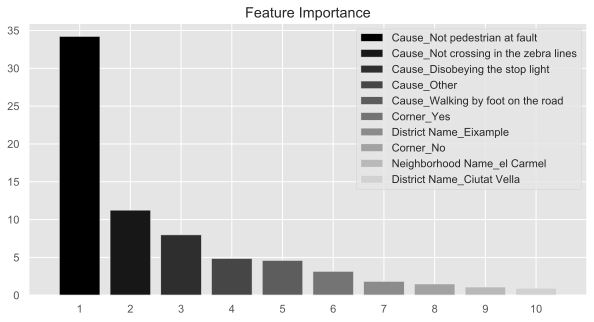

In [23]:
features = {}
for n in range(1,len(X.columns)+1):
    features[str("f" + str(n))] = X.columns[n-1]


xgb_reg = xgb.XGBClassifier(nthread=4, objective='reg:linear', learning_rate=0.1, colsample_bytree=0.5, n_estimators=50, max_depth=9, alpha=3)

xgb_reg.fit(X, yc)
importances = np.round(np.array(xgb_reg.feature_importances_)*100, decimals=2)
indices = np.argsort(importances)[::-1]

# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("{}. {}--> {}%".format(str(f + 1), features["f"+str(feature_indices[f])], str(importances[indices[f]])))
    
    
#Make a plot of the features importance   
plt.figure(figsize=(10,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), importances[indices[:num_to_plot]], color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]), align="center")
#ticks = plt.xticks(range(num_to_plot), feature_indices)
ticks = plt.xticks(range(num_to_plot), range(1,num_to_plot + 1) )
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

<p style = "font-family:arial;font-size:19px;">As a final task, we make a model limited just to predict if there were multiple cars involved in an accident. The algorithm used is Random Forest again.</p>

In [25]:
#Loadding and Labeling the variable.
ym = df[['Mult_Cars']]
ym = LabelEncoder().fit_transform(ym)

<p style = "font-family:arial;font-size:19px;">Our basic prediction model for this task has an accuracy of <b><i>78,12%</i></b></p>

In [26]:
df['Mult_Cars'].value_counts(True)*100

Yes    78.115
No     21.885
Name: Mult_Cars, dtype: float64

<p style = "font-family:arial;font-size:19px;">After a grid search, we compare the accuracy of this model with the one obtained for the prediction of the exact number of cars. 
We observe that the difference against the basic model is around <b><i>5%</i></b>. It is similar to the one obtained before.<br>
The final score absolute value is higher in this case because the problem is simpler.</p>

In [27]:
# Initialize the set of parameters for exhaustive search and fit 
parameters = {'n_estimators': [25, 50, 100],'max_features': [10, 15, 20, 24], 'min_samples_leaf': [1, 5, 9, 15], 'max_depth': [None , 9, 17, 19]}

rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gscv3 = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gscv3.fit(X, ym);

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 10.9min finished


In [28]:
#Making calculations for the score obtained.
cat_tuned_score = np.round(gscv3.best_score_*100, decimals=2)

#Printing the scores and the parameters.
print("The best accuracy obtained was {}% with this parameters: {}".format(cat_tuned_score ,gscv3.best_params_))
print("The improvement achieved  over the basic model is {}%".format(np.round(cat_tuned_score -78.12 , decimals=2)))

The best accuracy obtained was 83.45% with this parameters: {'max_depth': 17, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
The improvement achieved  over the basic model is 5.33%


<p style = "font-family:arial;font-size:19px;">Checking the features importance, we observe that the main ones are the same as before but the Cause: "Not pedestrian at fault" gain almost twice the importance and got closer to the XGboost model. The cause "Not crossing in the zebra lines" also got more importance in comparison.</p>

Feature ranking:
1. Cause_Not pedestrian at fault--> 29.38%
2. Latitude--> 9.11%
3. Cause_Disobeying the stop light--> 9.08%
4. Cause_Not crossing in the zebra lines--> 8.82%
5. Longitude--> 8.09%
6. Day--> 5.0%
7. Hour--> 4.94%
8. Month Number--> 3.81%
9. Cause_Other--> 3.55%
10. Weekday Number--> 3.12%


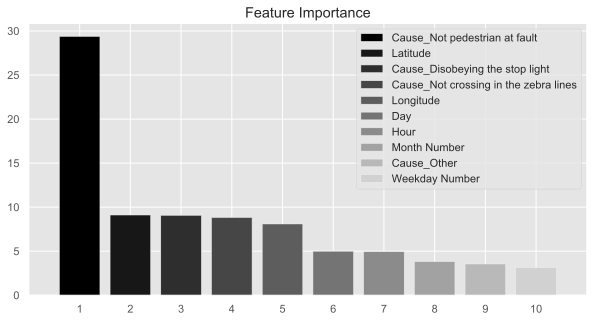

In [29]:
features = {}
for n in range(1,len(X.columns)+1):
    features[str("f" + str(n))] = X.columns[n-1]


rfc = RandomForestClassifier().set_params(**{'max_depth': 17, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 100})

rfc.fit(X, ym)
importances = np.round(np.array(rfc.feature_importances_)*100, decimals=2)
indices = np.argsort(importances)[::-1]

# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("{}. {}--> {}%".format(str(f + 1), features["f"+str(feature_indices[f])], str(importances[indices[f]])))
    
    
#Make a plot of the features importance   
plt.figure(figsize=(10,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), importances[indices[:num_to_plot]], color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]), align="center")
#ticks = plt.xticks(range(num_to_plot), feature_indices)
ticks = plt.xticks(range(num_to_plot), range(1,num_to_plot + 1) )
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

<font size="+2">
  <address>
Written by <a href="mailto:NahuelMS@hotmail.com">Nahuel Mussini</a><br>
  </address>
</font>